In [12]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
import os
import numpy as np
import random


class Reader(object):
    def __init__(self, dataset_dir, listfile=None):
        self._dataset_dir = dataset_dir
        self._current_index = 0
        if listfile is None:
            listfile_path = os.path.join(dataset_dir, "listfile.csv")
        else:
            listfile_path = listfile
        with open(listfile_path, "r") as lfile:
            self._data = lfile.readlines()
        self._listfile_header = self._data[0]
        self._data = self._data[1:]

    def get_number_of_examples(self):
        return len(self._data)

    def random_shuffle(self, seed=None):
        if seed is not None:
            random.seed(seed)
        random.shuffle(self._data)

    def read_example(self, index):
        raise NotImplementedError()

    def read_next(self):
        to_read_index = self._current_index
        self._current_index += 1
        if self._current_index == self.get_number_of_examples():
            self._current_index = 0
        return self.read_example(to_read_index)

In [14]:
class PhenotypingReader(Reader):
    def __init__(self, dataset_dir, listfile=None):
        """ Reader for phenotype classification task.

        :param dataset_dir: Directory where timeseries files are stored.
        :param listfile:    Path to a listfile. If this parameter is left `None` then
                            `dataset_dir/listfile.csv` will be used.
        """
        Reader.__init__(self, dataset_dir, listfile)
        self._data = [line.split(',') for line in self._data]
        self._data = [(mas[0], float(mas[1]), list(map(int, mas[2:]))) for mas in self._data]

    def _read_timeseries(self, ts_filename):
        ret = []
        with open(os.path.join(self._dataset_dir, ts_filename), "r") as tsfile:
            header = tsfile.readline().strip().split(',')
            assert header[0] == "Hours"
            for line in tsfile:
                mas = line.strip().split(',')
                ret.append(np.array(mas))
        return (np.stack(ret), header)

    def read_example(self, index):
        """ Reads the example with given index.

        :param index: Index of the line of the listfile to read (counting starts from 0).
        :return: Dictionary with the following keys:
            X : np.array
                2D array containing all events. Each row corresponds to a moment.
                First column is the time and other columns correspond to different
                variables.
            t : float
                Length of the data in hours. Note, in general, it is not equal to the
                timestamp of last event.
            y : array of ints
                Phenotype labels.
            header : array of strings
                Names of the columns. The ordering of the columns is always the same.
            name: Name of the sample.
        """
        if index < 0 or index >= len(self._data):
            raise ValueError("Index must be from 0 (inclusive) to number of lines (exclusive).")

        name = self._data[index][0]
        t = self._data[index][1]
        y = self._data[index][2]
        (X, header) = self._read_timeseries(name)

        return {"X": X,
                "t": t,
                "y": y,
                "header": header,
                "name": name}


In [15]:
dataset_dir = "C:\\Users\\samit\\OneDrive\\Desktop\\Datasets\\data\\phenotyping"
root_dir = r'C:\Users\samit\OneDrive\Desktop\Datasets\data\root'

In [9]:
import os

path = 'C:\\Users\\samit\\OneDrive\\Desktop\\Datasets\\data\\phenotyping\\train'
if os.path.exists(path):
    print("The file or directory exists.")
else:
    print("The file or directory does not exist.")


The file or directory exists.


In [16]:
train_reader = PhenotypingReader(dataset_dir=os.path.join(dataset_dir, 'train'),
                                         listfile=os.path.join(dataset_dir, 'train','listfile.csv'))


test_reader = PhenotypingReader(dataset_dir=os.path.join(dataset_dir, 'test'),
                                       listfile=os.path.join(dataset_dir, 'test','listfile.csv'))

In [17]:
print(train_reader.read_example(0))

{'X': array([['0.30527777777777776', '', '86.0', '', '1 No Response',
        '5 Localizes Pain', '7', '1.0 ET/Trach', '', '92', '', '104',
        '100.0', '14', '141.0', '', '', ''],
       ['0.47194444444444444', '', '', '', '', '', '', '', '142.0', '',
        '', '', '100.0', '14', '', '', '', ''],
       ['0.6719444444444445', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '7.43'],
       ['1.3052777777777778', '', '90.0', '', '', '', '', '', '', '98',
        '', '109', '100.0', '14', '144.0', '38.16669845581055', '', ''],
       ['2.3052777777777775', '', '90.0', '', '', '', '', '', '', '99',
        '', '109', '100.0', '14', '147.0', '', '', ''],
       ['3.3052777777777775', '', '93.0', '', '', '', '', '', '', '106',
        '', '113', '100.0', '14', '152.0', '39.11111195882162', '', ''],
       ['4.3052777777777775', '', '88.0', '', '', '', '', '', '', '106',
        '', '106', '100.0', '14', '145.0', '', '', ''],
       ['5.3052777777777775', '', '8

In [32]:
(train_reader.read_example(0)["y"])

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

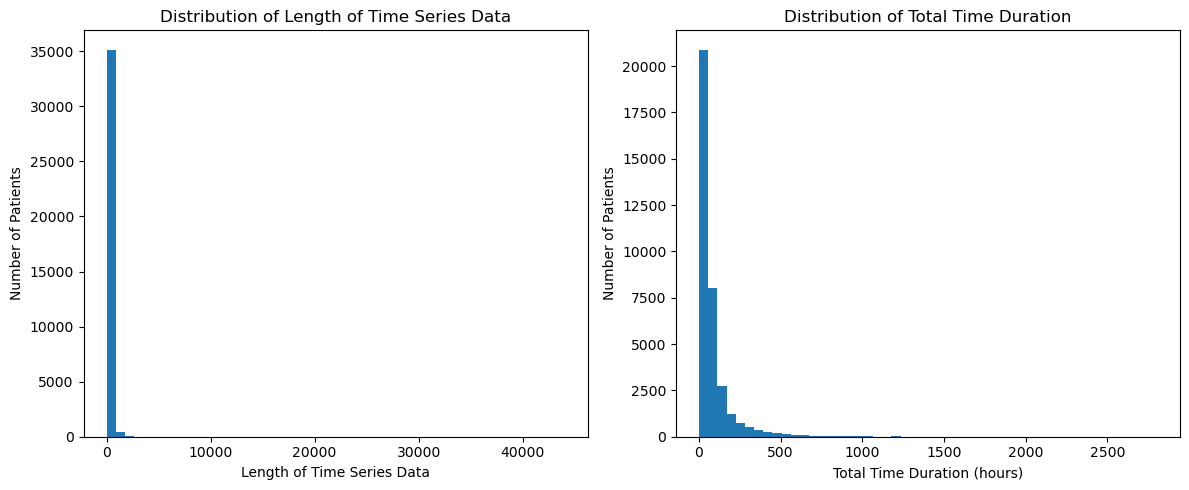

In [18]:
# Lists to store the length of the time series data and the total time duration for each patient
lengths = []
durations = []

# Loop through all the examples in the train_reader
for i in range(train_reader.get_number_of_examples()):
    example = train_reader.read_example(i)
    time_series_data = example['X']
    
    # Calculate the length of the time series data (number of data points)
    length = time_series_data.shape[0]
    lengths.append(length)
    
    # Calculate the total time duration
    durations.append(example['t'])

# Plot the distribution of the length of the time series data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(lengths, bins=50)
plt.xlabel('Length of Time Series Data')
plt.ylabel('Number of Patients')
plt.title('Distribution of Length of Time Series Data')

# Plot the distribution of the total time duration
plt.subplot(1, 2, 2)
plt.hist(durations, bins=50)
plt.xlabel('Total Time Duration (hours)')
plt.ylabel('Number of Patients')
plt.title('Distribution of Total Time Duration')

plt.tight_layout()
plt.show()

In [28]:
# Calculate the 90th percentile of the lengths and durations
percentile_90_length = np.percentile(lengths, 75)
percentile_90_duration = np.percentile(durations, 75)

print(f"Length corresponding to the 90th percentile: {percentile_90_length}")
print(f"Duration corresponding to the 90th percentile: {percentile_90_duration}")

Length corresponding to the 90th percentile: 129.0
Duration corresponding to the 90th percentile: 89.7576


In [30]:
np.mean(lengths)

134.32216950675164

In [18]:
import numpy as np

def discretize(data, timestep=0.8, impute_strategy='previous', start_time='zero'):
    """
    Discretizes the time series data into fixed timesteps and fills missing values.
    """
    # Sort data by time
    data = sorted(data, key=lambda x: float(x[0]))

    # Create an array for discretized data
    discretized_data = []

    # Fill missing values
    prev_values = None
    for i in range(len(data)):
        if i == 0 and start_time == 'zero':
            row = ['0.0'] + list(data[i][1:])  # Change 0 to '0.0' to match the data type
        else:
            row = list(data[i])

        if impute_strategy == 'previous':
            if prev_values is not None:
                row = [(row[j] if row[j] != '' else prev_values[j]) for j in range(len(row))]
            prev_values = row

        discretized_data.append(row)

    # Transform into fixed timestep format
    time_intervals = np.arange(0, max([float(row[0]) for row in discretized_data]) + timestep, timestep)
    fixed_timestep_data = []
    for t in time_intervals:
        fixed_timestep_data.append([str(t)] + [row[1:] for row in discretized_data if float(row[0]) <= t][-1])

    # Handle missing values (replace empty strings and non-numeric values with '0.0')
    #fixed_timestep_data = [[('0.0' if (cell == '' or not cell.replace('.', '', 1).isdigit()) else cell) for cell in row] for row in fixed_timestep_data]

    # Convert to numerical format and handle missing values
    
    # One-hot encode categorical variables
    # One-hot encode categorical variables
#     for i, channel in enumerate(CHANNELS.keys()):
#         if CHANNELS[channel] == 'categorical':
#             category_mapping = global_category_mapping[channel]
#             one_hot_encoded = np.zeros((len(fixed_timestep_data), len(category_mapping)))
#             for j, category in enumerate(category_mapping.keys()):
#                 one_hot_encoded[np.array(fixed_timestep_data)[:, i+1] == category, category_mapping[category]] = 1
#             fixed_timestep_data = np.column_stack((fixed_timestep_data, one_hot_encoded))
#             fixed_timestep_data = np.delete(fixed_timestep_data, i+1, axis=1)
    for i, channel in enumerate(CHANNELS.keys()):
        if CHANNELS[channel] == 'categorical':
            category_mapping = global_category_mapping[channel]
            fixed_timestep_data_array = np.array(fixed_timestep_data)
            for category, mapped_value in category_mapping.items():
                fixed_timestep_data_array[fixed_timestep_data_array[:, i+1] == category, i+1] = mapped_value
            fixed_timestep_data = fixed_timestep_data_array.tolist()



            
    fixed_timestep_data = [[('0.0' if (cell == '' or not cell.replace('.', '', 1).isdigit()) else cell) for cell in row] for row in fixed_timestep_data]

    df = pd.DataFrame(fixed_timestep_data, columns=['Time'] + ['Var' + str(i) for i in range(1, len(fixed_timestep_data[0]))])
    df = df.replace('', np.nan)
    df = df.fillna(method='ffill')
    df = df.fillna(0)  # Fill any remaining missing values with 0

    # Convert back to numpy array
    numerical_data = df.values.astype(np.float32)
#     numerical_data = np.array(fixed_timestep_data, dtype=np.float32)
#     numerical_data[np.isnan(numerical_data)] = 0


    return numerical_data








In [19]:
from sklearn.preprocessing import StandardScaler

def normalize(data):
    """
    Normalizes the data by scaling the continuous features to have a mean of 0 and a standard deviation of 1.
    """
    channels = CHANNELS
    # Separate time and features
    time = data[:, 0]
    features = data[:, 1:]

    # Identify the indices of the continuous and categorical features
    continuous_indices = [i for i, channel in enumerate(channels.keys()) if channels[channel] == 'numerical']
    categorical_indices = [i for i, channel in enumerate(channels.keys()) if channels[channel] == 'categorical']

    # Separate continuous and categorical features
    continuous_features = features[:, continuous_indices]
    categorical_features = features[:, categorical_indices]

    # Standardize the continuous features
    scaler = StandardScaler()
    standardized_continuous_features = scaler.fit_transform(continuous_features)

    # Create an empty array to hold the standardized features
    standardized_features = np.empty(features.shape, dtype=features.dtype)

    # Put the standardized continuous features back into their original positions
    for i, index in enumerate(continuous_indices):
        standardized_features[:, index] = standardized_continuous_features[:, i]

    # Put the transformed categorical features back into their original positions
    for i, index in enumerate(categorical_indices):
        standardized_features[:, index] = categorical_features[:, i]

    # Concatenate time and standardized features
    normalized_data = np.column_stack((time, standardized_features))

    return normalized_data



In [21]:
def pad_zeros(arr, max_length=142):
    """
    `arr` is an array of `np.array`s

    The function appends zeros to every `np.array` in `arr`
    to equalize their first axis lengths.
    """
    dtype = arr[0].dtype
    if max_length is None:
        max_len = max([x.shape[0] for x in arr])
    else:
        max_len = max_length
    ret = []
    for x in arr:
        if x.shape[0] > max_len:
            ret.append(x[:max_len, :])  # Truncate longer sequences
        else:
            ret.append(np.concatenate([x, np.zeros((max_len - x.shape[0],) + x.shape[1:], dtype=dtype)], axis=0))
    return np.array(ret)



In [22]:
CHANNELS = {
    'Capillary refill rate': 'categorical',
    'Diastolic blood pressure': 'numerical',
    'Fraction inspired oxygen': 'numerical',
    'Glascow coma scale eye opening': 'categorical',
    'Glascow coma scale motor response': 'categorical',
    'Glascow coma scale total': 'numerical',
    'Glascow coma scale verbal response': 'categorical',
    'Glucose': 'numerical',
    'Heart Rate': 'numerical',
    'Height': 'numerical',
    'Mean blood pressure': 'numerical',
    'Oxygen saturation': 'numerical',
    'Respiratory rate': 'numerical',
    'Systolic blood pressure': 'numerical',
    'Temperature': 'numerical',
    'Weight': 'numerical'
}


In [23]:
global_category_mapping = {'Capillary refill rate': {'': 0,
  '0.0': 1,
  '1': 2 },
  'Glascow coma scale eye opening': {'': 0,
  'To Pain': 1,
  'None': 2,
  'Spontaneously': 3,
  'To Speech': 4,
  '4 Spontaneously': 5,
  '1 No Response': 6,
  '2 To pain': 7,
  '3 To speech': 8},
 'Glascow coma scale motor response': {'': 0,
  'Localizes Pain': 1,
  '3 Abnorm flexion': 2,
  'Abnormal extension': 3,
  '5 Localizes Pain': 4,
  '6 Obeys Commands': 5,
  'Flex-withdraws': 6,
  '2 Abnorm extensn': 7,
  'Obeys Commands': 8,
  'Abnormal Flexion': 9,
  'No response': 10,
  '4 Flex-withdraws': 11,
  '1 No Response': 12},
 'Glascow coma scale verbal response': {'': 0,
  'Inappropriate Words': 1,
  'Incomprehensible sounds': 2,
  'Oriented': 3,
  '2 Incomp sounds': 4,
  '4 Confused': 5,
  'No Response-ETT': 6,
  '3 Inapprop words': 7,
  'Confused': 8,
  'No Response': 9,
  '1.0 ET/Trach': 10,
  '5 Oriented': 11,
  '1 No Response': 12}}

In [24]:
# Define the mappings for the categorical columns
admission_mapping = {'UNKNOWN': 0, 'EMERGENCY': 1, 'ELECTIVE': 2, 'URGENT': 3}
dbsource_mapping = {'carevue': 1, 'metavision': 2, 'both': 3}
icu_unit_mapping = {'MICU': 1, 'CCU': 2, 'TSICU': 3, 'SICU': 4, 'CSRU': 5}

def get_static_features(reader, index, root):
    # Read the example from the reader
    example = reader.read_example(index)
    
    # Extract the patient ID and episode number from the file name
    file_name = example['name']
    patient_id, episode_num = file_name.split('_')[0], file_name.split('_')[1].replace('episode', '')
    
    # Define the root directory and train folder
    if root == 'train':
        train_dir = os.path.join(root_dir, 'train')
    elif root == 'test':
        train_dir = os.path.join(root_dir, 'test')
    
    # Load the combined data
    combined_data = pd.read_csv('combined_data')
    
    # Access the patient folder
    patient_path = os.path.join(train_dir, patient_id)
    
    # Load the stays data
    stays_data = pd.read_csv(os.path.join(patient_path, 'stays.csv'))
    
    # Access the episode folder
    #episode_path = os.path.join(patient_path, f'episode{episode_num}')
    
    # Load the episode data
    episode_data = pd.read_csv(os.path.join(patient_path, f'episode{episode_num}.csv'))
    
    # Extract the relevant features
    age = episode_data['Age'].values[0]
    height = episode_data['Height'].values[0]
    weight = episode_data['Weight'].values[0]
    ethnicity = episode_data['Ethnicity'].values[0]
    gender = episode_data['Gender'].values[0]
    dbsource = stays_data['DBSOURCE'].values[0]
    last_careunit = stays_data['LAST_CAREUNIT'].values[0]
    
    # Get the admission type from the combined data
    # Get the admission type from the combined data
    icustay_id = stays_data['ICUSTAY_ID'].values[0]
    matching_rows = combined_data[combined_data['ICUSTAY_ID'] == icustay_id]

    if not matching_rows.empty:
        admission_type = matching_rows['ADMISSION_TYPE'].values[0]
    else:
        # Handle the case where there are no matching rows
        print(f"No matching rows found for ICUSTAY_ID {icustay_id}")
        admission_type = "UNKNOWN"

    
    # Create the static data vector
    static_data_vector = [age, height, weight, gender,ethnicity, dbsource, last_careunit, admission_type]
#     static_data_df = pd.DataFrame(static_data_vectors, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
#     # Apply the mappings to the static data DataFrame
#     static_data_df['AdmissionType'] = static_data_df['AdmissionType'].map(admission_mapping)
#     static_data_df['DBSource'] = static_data_df['DBSource'].map(dbsource_mapping)
#     static_data_df['LastCareUnit'] = static_data_df['LastCareUnit'].map(icu_unit_mapping)
#     static_data_vector = static_data_df.loc[0, :].values.tolist()

    return static_data_vector

In [29]:
from keras.utils import to_categorical
train_data_timeseries = []
train_data_static = []
train_labels = []
#drop_features = ['Height', 'Capillary refill rate']

for i in range(train_reader.get_number_of_examples()):
    example = train_reader.read_example(i)
    #     drop_indices = [example['header'].index(feature) for feature in drop_features]
    #     data = np.array(example['X'], dtype='<U20')
    #     data = np.delete(data, drop_indices, axis=1)
    #     example['X'] = data
    #     example['header'] = [header for j, header in enumerate(example['header']) if j not in drop_indices]
    discretized_data = discretize(example['X'])
    normalized_data = normalize(discretized_data)

    # Get the static data vector
    static_data_vector = get_static_features(train_reader, i,'train')
    for j in range(len(static_data_vector)):
        if isinstance(static_data_vector[j], (int, float)):
            static_data_vector[j] = float(static_data_vector[j])
        # Convert the static data vector into a numpy array and repeat it to match the shape of the time series data
    static_data_array = np.array(static_data_vector,dtype=object)
    #static_data_array = np.repeat(np.array(static_data_vector)[np.newaxis, :], normalized_data.shape[0], axis=0)

    # Concatenate the static data array with the time series data
    #concatenated_data = np.concatenate((normalized_data, static_data_array), axis=1)

    train_data_timeseries.append(normalized_data)
    train_data_static.append(static_data_array)
    train_labels.append(example['y'])
padded_train_data = pad_zeros(train_data_timeseries)
static_data_df = pd.DataFrame(train_data_static, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
static_data_df['AdmissionType'] = static_data_df['AdmissionType'].map(admission_mapping)
static_data_df['DBSource'] = static_data_df['DBSource'].map(dbsource_mapping)
static_data_df['LastCareUnit'] = static_data_df['LastCareUnit'].map(icu_unit_mapping)
numerical_features = ['Age', 'Height', 'Weight']
# Standardize the numerical features
scaler = StandardScaler()
scaler.fit(static_data_df[numerical_features])
static_data_df[numerical_features] = scaler.transform(static_data_df[numerical_features])
train_data_static = static_data_df.to_numpy()


test_data_timeseries = []
test_data_static = []
test_labels = []
for i in range(test_reader.get_number_of_examples()):
    example = test_reader.read_example(i)
#     drop_indices = [example['header'].index(feature) for feature in drop_features]
#     data = np.array(example['X'], dtype='<U20')
#     data = np.delete(data, drop_indices, axis=1)
#     example['X'] = data
#     example['header'] = [header for j, header in enumerate(example['header']) if j not in drop_indices]
    discretized_data = discretize(example['X'])
    normalized_data = normalize(discretized_data)

    # Get the static data vector
    static_data_vector_test = get_static_features(test_reader, i,'test')
    for j in range(len(static_data_vector_test)):
        if isinstance(static_data_vector_test[j], (int, float)):
            static_data_vector_test[j] = float(static_data_vector_test[j])

    # Convert the static data vector into a numpy array and repeat it to match the shape of the time series data
    static_data_array_test = np.array(static_data_vector_test, dtype=object)

    test_data_timeseries.append(normalized_data)
    test_data_static.append(static_data_array_test)
    test_labels.append(example['y'])
padded_test_data = pad_zeros(test_data_timeseries)
static_data_test_df = pd.DataFrame(test_data_static, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
static_data_test_df['AdmissionType'] = static_data_test_df['AdmissionType'].map(admission_mapping)
static_data_test_df['DBSource'] = static_data_test_df['DBSource'].map(dbsource_mapping)
static_data_test_df['LastCareUnit'] = static_data_test_df['LastCareUnit'].map(icu_unit_mapping)
static_data_test_df[numerical_features] = scaler.transform(static_data_test_df[numerical_features])
test_data_static = static_data_test_df.to_numpy()

No matching rows found for ICUSTAY_ID 283217


In [35]:
# import numpy as np

# # Assuming padded_train_data, train_labels, padded_test_data, and test_labels are already defined

# # Save train data and labels
# np.save('padded_train_data_pheno.npy', padded_train_data)
# np.save('train_labels_pheno.npy', train_labels)
# np.save('train_data_static_pheno.npy', train_data_static)
# # Save test data and labels
# np.save('padded_test_data_pheno.npy', padded_test_data)
# np.save('test_labels_pheno.npy', test_labels)
# np.save('test_data_static_pheno.npy', test_data_static)

In [30]:
train_labels

[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [68]:
# Indices of the 6 important columns
indices = [13, 9, 12, 11, 22, 23]

# Extract the columns
train_label = [[row[i] for i in indices] for row in train_labels]
test_label = [[row[i] for i in indices] for row in test_labels]


In [37]:
train_label

[[1, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 1, 0],
 [0, 1, 0, 1, 0, 0],
 [0, 1, 0, 1, 0, 1],
 [1, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0],
 [1, 0, 1, 0, 0, 0],
 [1, 1, 0, 1, 0, 0],
 [1, 1, 1, 1, 0, 0],
 [0, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [1, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 1],
 [0, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [0, 0, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0],
 [1, 0, 1, 0,

In [33]:
padded_train_data.shape

(35621, 142, 18)

In [38]:
import numpy as np

# Calculate the number of nan values in each column of padded_train_data
nan_counts_padded = np.isnan(padded_train_data).sum(axis=0)

# Calculate the total number of values in each column of padded_train_data
total_counts_padded = padded_train_data.shape[0]

# Calculate the percentage of nan values in each column of padded_train_data
nan_percentage_padded = (nan_counts_padded / total_counts_padded) * 100

# Calculate the number of nan values in each column of train_static_data
nan_counts_static = np.isnan(train_data_static).sum(axis=0)

# Calculate the total number of values in each column of train_static_data
total_counts_static = train_data_static.shape[0]

# Calculate the percentage of nan values in each column of train_static_data
nan_percentage_static = (nan_counts_static / total_counts_static) * 100

print("Percentage of nan values in each column of padded_train_data:", nan_percentage_padded)
print("Percentage of nan values in each column of train_static_data:", nan_percentage_static)

Percentage of nan values in each column of padded_train_data: [[0.         0.         0.         ... 0.         0.         1.19592375]
 [0.         0.         0.         ... 0.         0.         1.30540973]
 [0.         0.         0.         ... 0.         0.         1.73493164]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.01122933]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Percentage of nan values in each column of train_static_data: [ 0.         77.58906263 18.3768002   0.          0.          0.
  0.          0.        ]


In [39]:
for i in range(padded_train_data.shape[0]):
    for j in range(padded_train_data.shape[1]):
        dataset = padded_train_data[i, j, :]
        nan_indices = np.isnan(dataset)
        mean_value = np.nanmean(dataset)
        dataset[nan_indices] = mean_value
        padded_train_data[i, j, :] = dataset

In [40]:
for i in range(padded_test_data.shape[0]):
    for j in range(padded_test_data.shape[1]):
        dataset = padded_test_data[i, j, :]
        nan_indices = np.isnan(dataset)
        mean_value = np.nanmean(dataset)
        dataset[nan_indices] = mean_value
        padded_test_data[i, j, :] = dataset

In [41]:
import numpy as np

# Assuming val_data_static is a numpy array
column_index_to_drop = 1  # Index of the column with 74.45% nan values
train_data_static = np.delete(train_data_static, column_index_to_drop, axis=1)
test_data_static = np.delete(test_data_static,column_index_to_drop, axis=1 ) 

In [42]:
import numpy as np

# Assuming train_static_data and val_static_data are your static data arrays
# Assuming the weight column is the second column (index 1)

# Calculate the mean of the non-missing values in the weight column of the training data
mean_weight_train = np.nanmean(train_data_static[:, 1])

# Impute the missing values in the weight column of the training data with the mean
train_data_static[:, 1] = np.where(np.isnan(train_data_static[:, 1]), mean_weight_train, train_data_static[:, 1])

# Impute the missing values in the weight column of the validation data with the mean from the training data
test_data_static[:, 1] = np.where(np.isnan(test_data_static[:, 1]), mean_weight_train, test_data_static[:, 1])

In [43]:
padded_train_data.shape

(35621, 142, 18)

In [70]:
# from keras.layers import BatchNormalization, Masking
# from keras.optimizers import Adam

# # Define the input shape for the time series data
# time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# # Add a masking layer to ignore the padded zeros
# masking_layer = Masking(mask_value=0.0)(time_series_input)

# # Define the LSTM layers for the time series data
# lstm_layer = LSTM(64, return_sequences=True)(masking_layer)
# lstm_layer = BatchNormalization()(lstm_layer)  # Add Batch Normalization
# lstm_layer = LSTM(32)(lstm_layer)
# lstm_layer = BatchNormalization()(lstm_layer)  # Add Batch Normalization

# # Concatenate the LSTM output with the static features
# concat_layer = Concatenate()([lstm_layer, static_input])

# # Define the dense layers
# dense_layer = Dense(64, activation='relu')(concat_layer)
# dense_layer = BatchNormalization()(dense_layer)  # Add Batch Normalization
# dense_layer = Dropout(0.3)(dense_layer)
# dense_layer = Dense(32, activation='relu')(dense_layer)
# dense_layer = BatchNormalization()(dense_layer)  # Add Batch Normalization
# dense_layer = Dropout(0.3)(dense_layer)

# # Get the number of classes from the one-hot encoded labels
# num_classes = len(train_label[0])

# # Define the output layer with softmax activation function
# output_layer = Dense(num_classes, activation='softmax')(dense_layer)

# # Create the model
# model = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# # Define a custom learning rate for the Adam optimizer
# optimizer = Adam(learning_rate=0.001)  # You can reduce this further if needed

# # Compile the model
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# # Print the model summary
# model.summary()



In [91]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Define the LSTM layers for the time series data
lstm_layer = LSTM(64, return_sequences=True)(time_series_input)
lstm_layer = LSTM(32)(lstm_layer)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([lstm_layer, static_input]) 

# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add a Dropout layer with a rate of 0.3
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add another Dropout layer with a rate of 0.3

# Define the output layer for multi-label classification (use sigmoid activation)
num_classes = len(train_label[0]) # Get the number of classes from the one-hot encoded labels
output_layer = Dense(num_classes, activation='sigmoid')(dense_layer)  # Change to sigmoid

# Create the model
model = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model with binary_crossentropy loss for multi-label classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change to binary_crossentropy

# Print the model summary
model.summary()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, None, 18)]   0           []                               
                                                                                                  
 lstm_126 (LSTM)                (None, None, 64)     21248       ['input_23[0][0]']               
                                                                                                  
 lstm_127 (LSTM)                (None, 32)           12416       ['lstm_126[0][0]']               
                                                                                                  
 input_24 (InputLayer)          [(None, 7)]          0           []                               
                                                                                           

In [92]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
train_labels_arr = np.array(train_label)
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Model checkpoint callback
checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

callbacks = [early_stopping, checkpoint, reduce_lr]

history = model.fit(
    [padded_train_data, train_data_static], train_labels_arr,
    validation_split=0.15,
    epochs=20,
    batch_size=64,  # Increased batch size
    shuffle=True,   # Ensure data is shuffled
    callbacks=callbacks
)



Epoch 1/20
474/474 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.4815
Epoch 1: val_loss improved from inf to 0.51070, saving model to best_model_weights.h5
474/474 [==============================] - 90s 181ms/step - loss: 0.5421 - accuracy: 0.4815 - val_loss: 0.5107 - val_accuracy: 0.6203 - lr: 0.0010
Epoch 2/20
474/474 [==============================] - ETA: 0s - loss: 0.5086 - accuracy: 0.5499
Epoch 2: val_loss improved from 0.51070 to 0.49774, saving model to best_model_weights.h5
474/474 [==============================] - 104s 220ms/step - loss: 0.5086 - accuracy: 0.5499 - val_loss: 0.4977 - val_accuracy: 0.5709 - lr: 0.0010
Epoch 3/20
474/474 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.5573
Epoch 3: val_loss improved from 0.49774 to 0.49491, saving model to best_model_weights.h5
474/474 [==============================] - 104s 220ms/step - loss: 0.4998 - accuracy: 0.5573 - val_loss: 0.4949 - val_accuracy: 0.5997 - lr: 0.0010
Epo

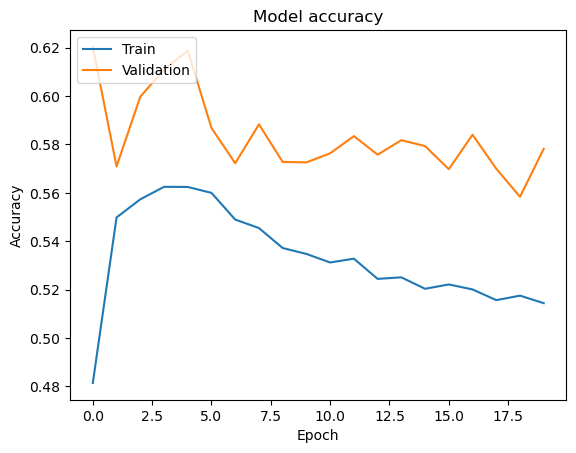

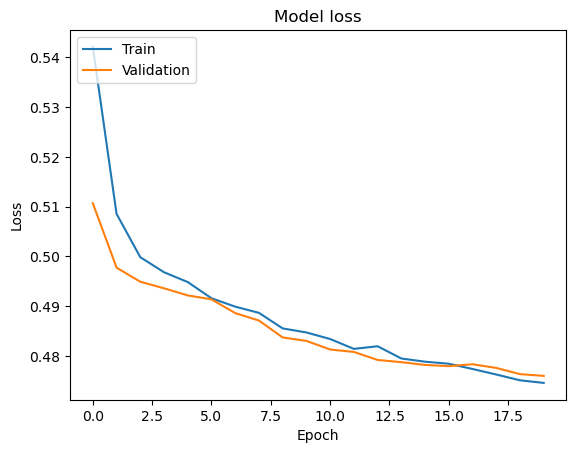

In [100]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [93]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Create separate LSTM layers for each channel in the time series data
lstm_outputs = []
for i in range(padded_train_data.shape[2]):
    channel_input = time_series_input[:,:,i:i+1]  # Select the i-th channel from the input data
    lstm_layer = LSTM(64, return_sequences=True)(channel_input)
    lstm_layer = LSTM(32)(lstm_layer)
    lstm_outputs.append(lstm_layer)

# Concatenate the outputs of the LSTM layers
concat_lstm = Concatenate()(lstm_outputs)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([concat_lstm, static_input])

# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add a Dropout layer with a rate of 0.5
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add another Dropout layer with a rate of 0.5
# Define the output layer for multi-class classification (use softmax activation)
# Define the output layer for multi-label classification (use sigmoid activation)
num_classes = len(train_label[0]) # Get the number of classes from the one-hot encoded labels
output_layer = Dense(num_classes, activation='sigmoid')(dense_layer)  # Change to sigmoid

# Create the model
model3 = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model with binary_crossentropy loss for multi-label classification
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change to binary_crossentropy

# Print the model summary
model3.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, None, 18)]   0           []                               
                                                                                                  
 tf.__operators__.getitem_54 (S  (None, None, 1)     0           ['input_25[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_55 (S  (None, None, 1)     0           ['input_25[0][0]']               
 licingOpLambda)                                                                                  
                                                                                           

In [94]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Model checkpoint callback
checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

callbacks = [early_stopping, checkpoint, reduce_lr]

history3 = model3.fit(
    [padded_train_data, train_data_static], train_labels_arr,
    validation_split=0.15,
    epochs=10,
    batch_size=64,  # Increased batch size
    shuffle=True,   # Ensure data is shuffled
    callbacks=callbacks
)

Epoch 1/10
474/474 [==============================] - ETA: 0s - loss: 0.5447 - accuracy: 0.4547
Epoch 1: val_loss improved from inf to 0.50695, saving model to best_model_weights.h5
474/474 [==============================] - 4625s 10s/step - loss: 0.5447 - accuracy: 0.4547 - val_loss: 0.5070 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 2/10
474/474 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.5581
Epoch 2: val_loss improved from 0.50695 to 0.49613, saving model to best_model_weights.h5
474/474 [==============================] - 4128s 9s/step - loss: 0.5056 - accuracy: 0.5581 - val_loss: 0.4961 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 3/10
474/474 [==============================] - ETA: 0s - loss: 0.4991 - accuracy: 0.5749
Epoch 3: val_loss improved from 0.49613 to 0.49414, saving model to best_model_weights.h5
474/474 [==============================] - 4080s 9s/step - loss: 0.4991 - accuracy: 0.5749 - val_loss: 0.4941 - val_accuracy: 0.6248 - lr: 0.0010
Epoch 4

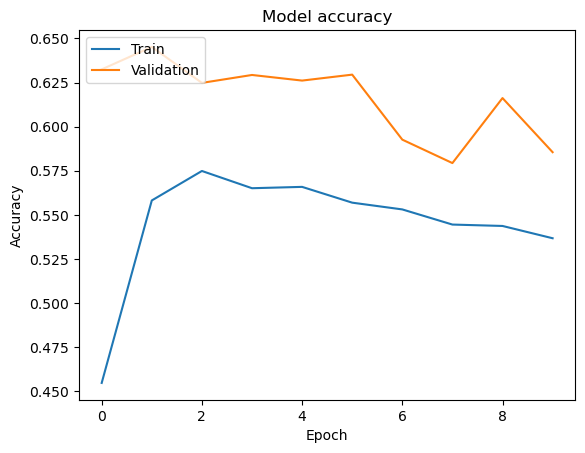

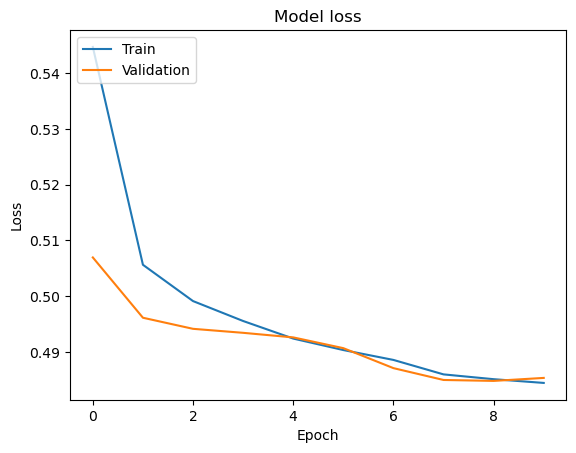

In [101]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [95]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Bidirectional

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Define the Bidirectional LSTM layers for the time series data
bi_lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(time_series_input)
bi_lstm_layer = Bidirectional(LSTM(32))(bi_lstm_layer)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([bi_lstm_layer, static_input])

# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.2)(dense_layer)  # Add a Dropout layer with a rate of 0.5
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.2)(dense_layer)  # Add another Dropout layer with a rate of 0.5

# Define the output layer for multi-label classification (use sigmoid activation)
num_classes = len(train_label[0]) # Get the number of classes from the one-hot encoded labels
output_layer = Dense(num_classes, activation='sigmoid')(dense_layer)  # Change to sigmoid

# Create the model
model1 = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model with binary_crossentropy loss for multi-label classification
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change to binary_crossentropy

# Print the model summary
model1.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, None, 18)]   0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 128)    42496       ['input_27[0][0]']               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 64)          41216       ['bidirectional[0][0]']          
 )                                                                                                
                                                                                                  
 input_28 (InputLayer)          [(None, 7)]          0           []                        

In [96]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Model checkpoint callback
checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

callbacks = [early_stopping, checkpoint, reduce_lr]

history1 = model1.fit(
    [padded_train_data, train_data_static], train_labels_arr,
    validation_split=0.15,
    epochs=20,
    batch_size=64,  # Increased batch size
    shuffle=True,   # Ensure data is shuffled
    callbacks=callbacks
)

Epoch 1/20
474/474 [==============================] - ETA: 0s - loss: 0.5272 - accuracy: 0.4683
Epoch 1: val_loss improved from inf to 0.49688, saving model to best_model_weights.h5
474/474 [==============================] - 376s 774ms/step - loss: 0.5272 - accuracy: 0.4683 - val_loss: 0.4969 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 2/20
474/474 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.5160
Epoch 2: val_loss improved from 0.49688 to 0.48781, saving model to best_model_weights.h5
474/474 [==============================] - 362s 764ms/step - loss: 0.4934 - accuracy: 0.5160 - val_loss: 0.4878 - val_accuracy: 0.5698 - lr: 0.0010
Epoch 3/20
474/474 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.5198
Epoch 3: val_loss improved from 0.48781 to 0.48195, saving model to best_model_weights.h5
474/474 [==============================] - 367s 774ms/step - loss: 0.4843 - accuracy: 0.5198 - val_loss: 0.4820 - val_accuracy: 0.5704 - lr: 0.0010
Ep

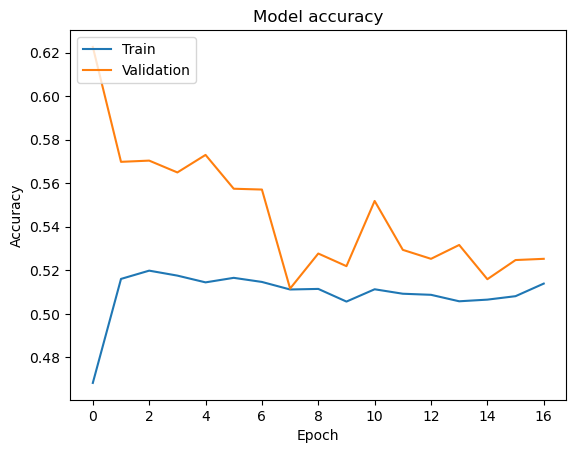

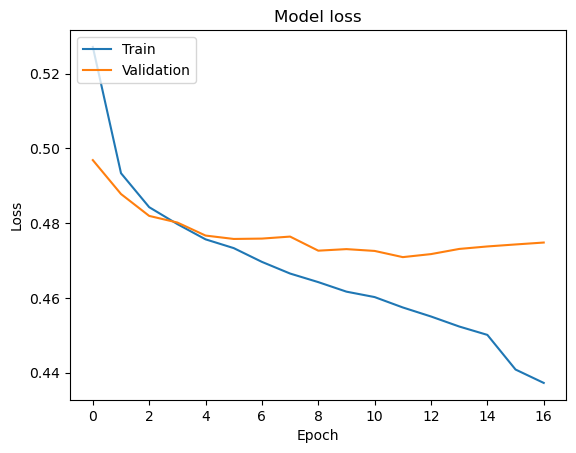

In [102]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [97]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# Define model parameters
input_shape = (padded_train_data.shape[1], padded_train_data.shape[2])


# Build the LSTM model
model2 = Sequential()
model2.add(LSTM(64, input_shape=input_shape, return_sequences=True))
model2.add(Dropout(0.3))  # Add dropout layer with 20% dropout rate
model2.add(LSTM(32))
model2.add(Dropout(0.3))  # Add dropout layer with 20% dropout rate
num_classes = len(train_label[0]) # Get the number of classes from the one-hot encoded labels
model2.add(Dense(num_classes, activation='sigmoid'))

# Compile the model with binary_crossentropy loss for multi-label classification
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change to binary_crossentropy

# Print the model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_166 (LSTM)             (None, 142, 64)           21248     
                                                                 
 dropout_30 (Dropout)        (None, 142, 64)           0         
                                                                 
 lstm_167 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_45 (Dense)            (None, 6)                 198       
                                                                 
Total params: 33,862
Trainable params: 33,862
Non-trainable params: 0
_________________________________________________________________


In [98]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Model checkpoint callback
checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

callbacks = [early_stopping, checkpoint, reduce_lr]

history2 = model2.fit(
    padded_train_data, train_labels_arr,
    validation_split=0.15,
    epochs=20,
    batch_size=64,  # Increased batch size
    shuffle=True,   # Ensure data is shuffled
    callbacks=callbacks
)

Epoch 1/20
474/474 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.5156
Epoch 1: val_loss improved from inf to 0.53903, saving model to best_model_weights.h5
474/474 [==============================] - 162s 318ms/step - loss: 0.5474 - accuracy: 0.5156 - val_loss: 0.5390 - val_accuracy: 0.6055 - lr: 0.0010
Epoch 2/20
474/474 [==============================] - ETA: 0s - loss: 0.5376 - accuracy: 0.5762
Epoch 2: val_loss improved from 0.53903 to 0.53860, saving model to best_model_weights.h5
474/474 [==============================] - 158s 333ms/step - loss: 0.5376 - accuracy: 0.5762 - val_loss: 0.5386 - val_accuracy: 0.6286 - lr: 0.0010
Epoch 3/20
474/474 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.6004
Epoch 3: val_loss improved from 0.53860 to 0.53762, saving model to best_model_weights.h5
474/474 [==============================] - 156s 329ms/step - loss: 0.5364 - accuracy: 0.6004 - val_loss: 0.5376 - val_accuracy: 0.6286 - lr: 0.0010
Ep

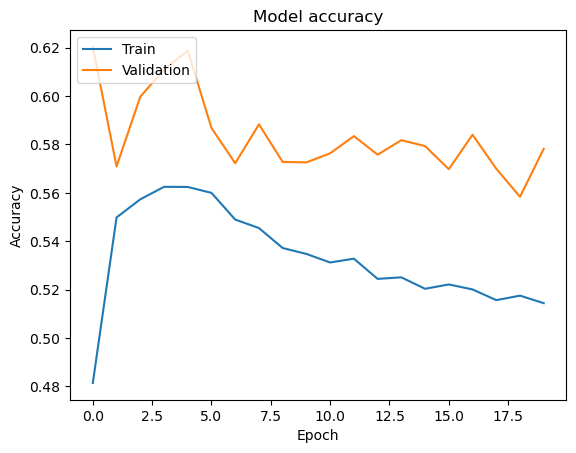

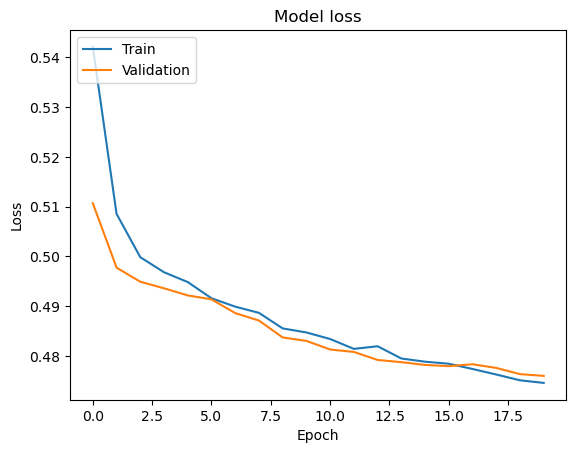

In [99]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


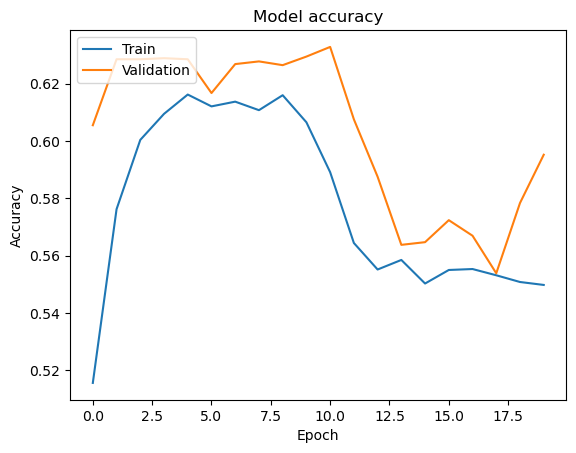

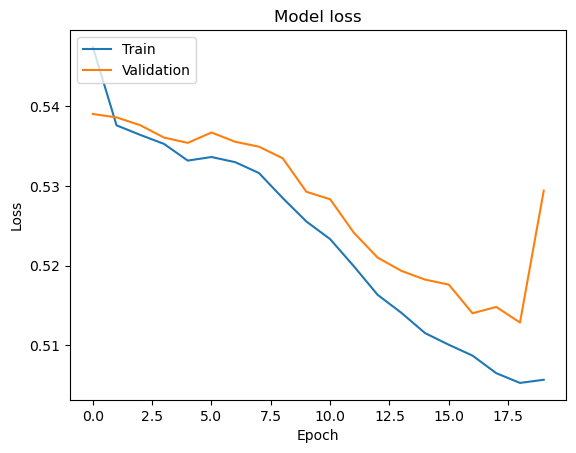

In [103]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


197/197 [==============================] - 18s 91ms/step
Normal LSTM - Micro AUC-ROC: 0.7844
Normal LSTM - Macro AUC-ROC: 0.7466
                                                    precision    recall  f1-score   support

                            Essential hypertension       0.59      0.42      0.49      2657
  Coronary atherosclerosis and other heart disease       0.73      0.46      0.56      2076
                     Disorders of lipid metabolism       0.63      0.18      0.28      1814
            Diabetes mellitus without complication       0.00      0.00      0.00      1206
Respiratory failure; insufficiency; arrest (adult)       0.71      0.31      0.43      1111
                      Septicemia (except in labor)       0.50      0.00      0.01       875

                                         micro avg       0.65      0.28      0.39      9739
                                         macro avg       0.53      0.23      0.29      9739
                                      wei

C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


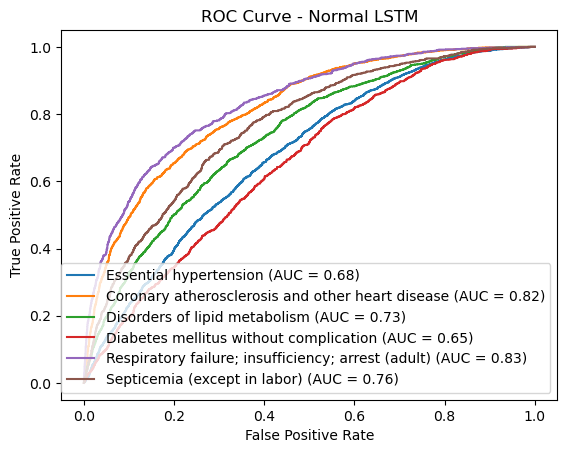

Confusion Matrix for Essential hypertension:
[[2863  761]
 [1550 1107]]
Confusion Matrix for Coronary atherosclerosis and other heart disease:
[[3844  361]
 [1122  954]]
Confusion Matrix for Disorders of lipid metabolism:
[[4269  198]
 [1482  332]]
Confusion Matrix for Diabetes mellitus without complication:
[[5075    0]
 [1206    0]]
Confusion Matrix for Respiratory failure; insufficiency; arrest (adult):
[[5028  142]
 [ 770  341]]
Confusion Matrix for Septicemia (except in labor):
[[5403    3]
 [ 872    3]]
197/197 [==============================] - 45s 217ms/step
Bidirectional LSTM - Micro AUC-ROC: 0.7884
Bidirectional LSTM - Macro AUC-ROC: 0.7509
                                                    precision    recall  f1-score   support

                            Essential hypertension       0.60      0.43      0.50      2657
  Coronary atherosclerosis and other heart disease       0.73      0.46      0.56      2076
                     Disorders of lipid metabolism       0.60   

C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


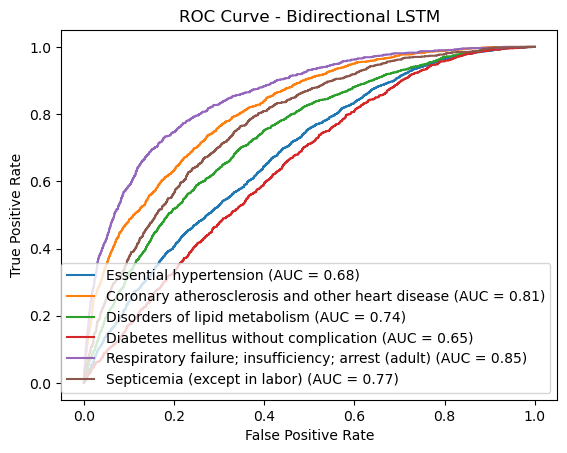

Confusion Matrix for Essential hypertension:
[[2851  773]
 [1518 1139]]
Confusion Matrix for Coronary atherosclerosis and other heart disease:
[[3848  357]
 [1129  947]]
Confusion Matrix for Disorders of lipid metabolism:
[[4194  273]
 [1407  407]]
Confusion Matrix for Diabetes mellitus without complication:
[[5075    0]
 [1206    0]]
Confusion Matrix for Respiratory failure; insufficiency; arrest (adult):
[[4869  301]
 [ 594  517]]
Confusion Matrix for Septicemia (except in labor):
[[5350   56]
 [ 806   69]]
197/197 [==============================] - 19s 90ms/step
LSTM without Multimodality - Micro AUC-ROC: 0.6969
LSTM without Multimodality - Macro AUC-ROC: 0.6450
                                                    precision    recall  f1-score   support

                            Essential hypertension       0.62      0.14      0.22      2657
  Coronary atherosclerosis and other heart disease       0.73      0.21      0.33      2076
                     Disorders of lipid metabolis

C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


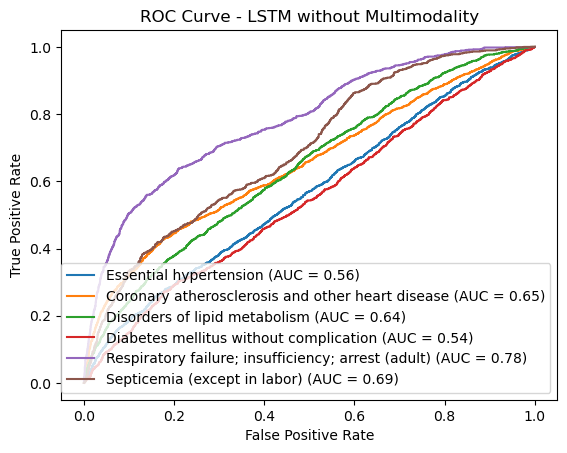

Confusion Matrix for Essential hypertension:
[[3406  218]
 [2298  359]]
Confusion Matrix for Coronary atherosclerosis and other heart disease:
[[4043  162]
 [1635  441]]
Confusion Matrix for Disorders of lipid metabolism:
[[4289  178]
 [1565  249]]
Confusion Matrix for Diabetes mellitus without complication:
[[5075    0]
 [1206    0]]
Confusion Matrix for Respiratory failure; insufficiency; arrest (adult):
[[5020  150]
 [ 815  296]]
Confusion Matrix for Septicemia (except in labor):
[[5406    0]
 [ 875    0]]
197/197 [==============================] - 225s 1s/step
Channel-wise LSTM - Micro AUC-ROC: 0.7724
Channel-wise LSTM - Macro AUC-ROC: 0.7315
                                                    precision    recall  f1-score   support

                            Essential hypertension       0.59      0.42      0.49      2657
  Coronary atherosclerosis and other heart disease       0.73      0.36      0.48      2076
                     Disorders of lipid metabolism       0.59      0

C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


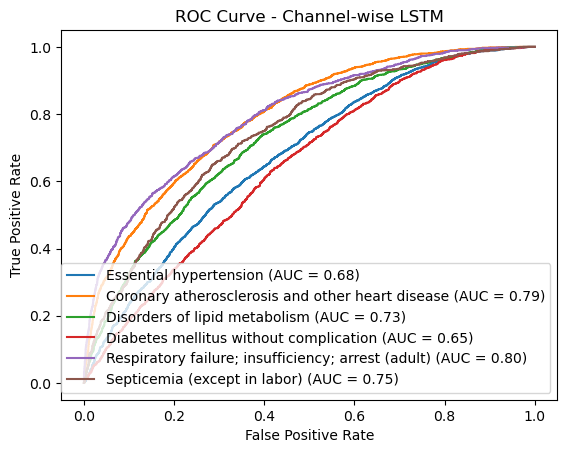

Confusion Matrix for Essential hypertension:
[[2847  777]
 [1530 1127]]
Confusion Matrix for Coronary atherosclerosis and other heart disease:
[[3919  286]
 [1321  755]]
Confusion Matrix for Disorders of lipid metabolism:
[[4192  275]
 [1411  403]]
Confusion Matrix for Diabetes mellitus without complication:
[[5075    0]
 [1206    0]]
Confusion Matrix for Respiratory failure; insufficiency; arrest (adult):
[[5034  136]
 [ 796  315]]
Confusion Matrix for Septicemia (except in labor):
[[5404    2]
 [ 875    0]]


In [106]:
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# List of models and their names
models = [model, model1, model2, model3]
model_names = ["Normal LSTM", "Bidirectional LSTM", "LSTM without Multimodality", "Channel-wise LSTM"]

# Disease names
disease_names = [
    "Essential hypertension",
    "Coronary atherosclerosis and other heart disease",
    "Disorders of lipid metabolism",
    "Diabetes mellitus without complication",
    "Respiratory failure; insufficiency; arrest (adult)",
    "Septicemia (except in labor)"
]
# To store AUC values for heatmap
auc_values = []

for idx, model in enumerate(models):
    # Predict probabilities
    if model_names[idx] == "LSTM without Multimodality":
        y_pred = model.predict(padded_test_data)
    else:
        y_pred = model.predict([padded_test_data, test_data_static])
    
    # Compute and print micro and macro AUC-ROC
    roc_auc_micro = roc_auc_score(test_label, y_pred, average="micro")
    roc_auc_macro = roc_auc_score(test_label, y_pred, average="macro")
    print(f"{model_names[idx]} - Micro AUC-ROC: {roc_auc_micro:.4f}")
    print(f"{model_names[idx]} - Macro AUC-ROC: {roc_auc_macro:.4f}")
    
    # Classification report
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # Convert probabilities to binary outputs
    print(classification_report(test_label, y_pred_binary, target_names=disease_names))
    
    # Plot ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    test_label_arr = np.array(test_label)
    for i in range(6):  # Assuming 6 classes
        fpr[i], tpr[i], _ = roc_curve(test_label_arr[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{disease_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.title(f'ROC Curve - {model_names[idx]}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    auc_values.append([roc_auc[i] for i in range(6)])
    # Confusion matrix for each class
    for i in range(6):  # Assuming 6 classes
        matrix = confusion_matrix(test_label_arr[:, i], y_pred_binary[:, i])
        print(f"Confusion Matrix for {disease_names[i]}:")
        print(matrix)


In [131]:
# import numpy as np
# from sklearn.metrics import roc_auc_score, roc_curve, auc
# import matplotlib.pyplot as plt

# # List of models and their names
# models = [model, model1, model2, model3]
# model_names = ["Normal LSTM", "Bidirectional LSTM", "LSTM without Multimodality", "Channel-wise LSTM"]

# # Convert test_label to a NumPy array
# test_label_arr = np.array(test_label)

# # Plot Micro AUC-ROC
# plt.figure(figsize=(10, 6))
# for idx, current_model in enumerate(models):
#     if model_names[idx] == "LSTM without Multimodality":
#         y_pred = current_model.predict(padded_test_data)
#     else:
#         y_pred = current_model.predict([padded_test_data, test_data_static])
    
#     # Compute ROC curve and ROC area for micro-average
#     fpr_micro, tpr_micro, _ = roc_curve(test_label_arr.ravel(), y_pred.ravel())
#     roc_auc_micro = auc(fpr_micro, tpr_micro)
#     plt.plot(fpr_micro, tpr_micro, label=f'{model_names[idx]} (AUC = {roc_auc_micro:.2f})')

# plt.title('Micro-average ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend(loc="lower right")
# plt.show()

# # Plot Macro AUC-ROC
# plt.figure(figsize=(10, 6))
# for idx, current_model in enumerate(models):
#     if model_names[idx] == "LSTM without Multimodality":
#         y_pred = current_model.predict(padded_test_data)
#     else:
#         y_pred = current_model.predict([padded_test_data, test_data_static])
    
#     # Compute ROC curve and ROC area for each class, then average for macro-average
#     fpr_macro = dict()
#     tpr_macro = dict()
#     for i in range(6):  # Assuming 6 classes
#         fpr_macro[i], tpr_macro[i], _ = roc_curve(test_label_arr[:, i], y_pred[:, i])
#     all_fpr = np.unique(np.concatenate([fpr_macro[i] for i in range(6)]))
#     mean_tpr = np.zeros_like(all_fpr)
#     for i in range(6):
#         mean_tpr += np.interp(all_fpr, fpr_macro[i], tpr_macro[i])
#     mean_tpr /= 6
#     roc_auc_macro = auc(all_fpr, mean_tpr)
#     plt.plot(all_fpr, mean_tpr, label=f'{model_names[idx]} (AUC = {roc_auc_macro:.2f})')

# plt.title('Macro-average ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend(loc="lower right")
# plt.show()


197/197 [==============================] - 173s 876ms/step
Normal LSTM - Micro AUC-ROC: 0.7724
Normal LSTM - Macro AUC-ROC: 0.7315
                                                    precision    recall  f1-score   support

                            Essential hypertension       0.59      0.42      0.49      2657
  Coronary atherosclerosis and other heart disease       0.73      0.36      0.48      2076
                     Disorders of lipid metabolism       0.59      0.22      0.32      1814
            Diabetes mellitus without complication       0.00      0.00      0.00      1206
Respiratory failure; insufficiency; arrest (adult)       0.70      0.28      0.40      1111
                      Septicemia (except in labor)       0.00      0.00      0.00       875

                                         micro avg       0.64      0.27      0.38      9739
                                         macro avg       0.44      0.22      0.28      9739
                                      w

C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


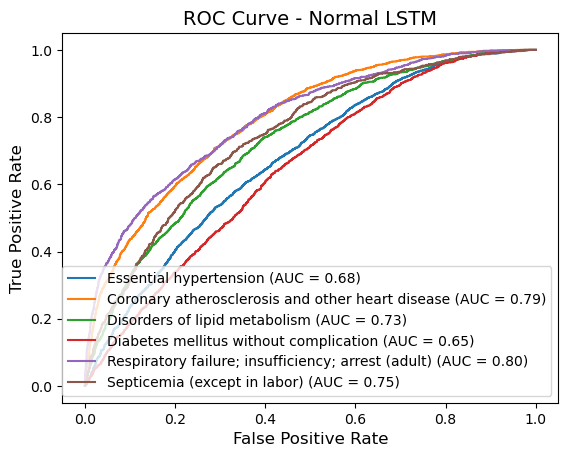

197/197 [==============================] - 31s 156ms/step
Bidirectional LSTM - Micro AUC-ROC: 0.7884
Bidirectional LSTM - Macro AUC-ROC: 0.7509
                                                    precision    recall  f1-score   support

                            Essential hypertension       0.60      0.43      0.50      2657
  Coronary atherosclerosis and other heart disease       0.73      0.46      0.56      2076
                     Disorders of lipid metabolism       0.60      0.22      0.33      1814
            Diabetes mellitus without complication       0.00      0.00      0.00      1206
Respiratory failure; insufficiency; arrest (adult)       0.63      0.47      0.54      1111
                      Septicemia (except in labor)       0.55      0.08      0.14       875

                                         micro avg       0.64      0.32      0.42      9739
                                         macro avg       0.52      0.28      0.34      9739
                          

C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


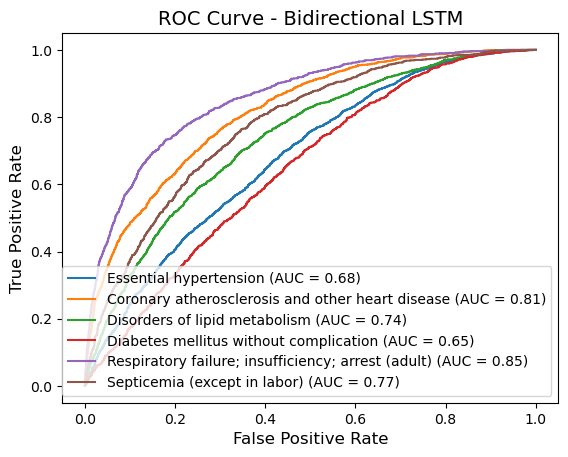

197/197 [==============================] - 14s 72ms/step
LSTM without Multimodality - Micro AUC-ROC: 0.6969
LSTM without Multimodality - Macro AUC-ROC: 0.6450
                                                    precision    recall  f1-score   support

                            Essential hypertension       0.62      0.14      0.22      2657
  Coronary atherosclerosis and other heart disease       0.73      0.21      0.33      2076
                     Disorders of lipid metabolism       0.58      0.14      0.22      1814
            Diabetes mellitus without complication       0.00      0.00      0.00      1206
Respiratory failure; insufficiency; arrest (adult)       0.66      0.27      0.38      1111
                      Septicemia (except in labor)       0.00      0.00      0.00       875

                                         micro avg       0.66      0.14      0.23      9739
                                         macro avg       0.43      0.13      0.19      9739
           

C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


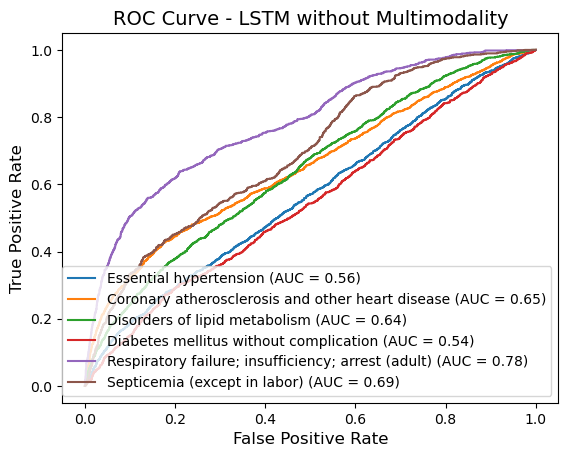

197/197 [==============================] - 162s 824ms/step
Channel-wise LSTM - Micro AUC-ROC: 0.7724
Channel-wise LSTM - Macro AUC-ROC: 0.7315
                                                    precision    recall  f1-score   support

                            Essential hypertension       0.59      0.42      0.49      2657
  Coronary atherosclerosis and other heart disease       0.73      0.36      0.48      2076
                     Disorders of lipid metabolism       0.59      0.22      0.32      1814
            Diabetes mellitus without complication       0.00      0.00      0.00      1206
Respiratory failure; insufficiency; arrest (adult)       0.70      0.28      0.40      1111
                      Septicemia (except in labor)       0.00      0.00      0.00       875

                                         micro avg       0.64      0.27      0.38      9739
                                         macro avg       0.44      0.22      0.28      9739
                           

C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


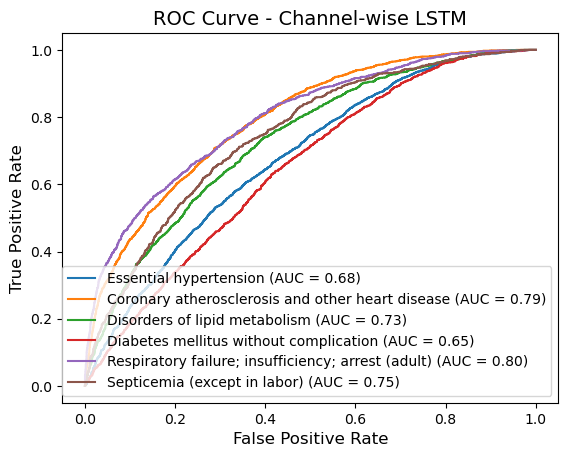

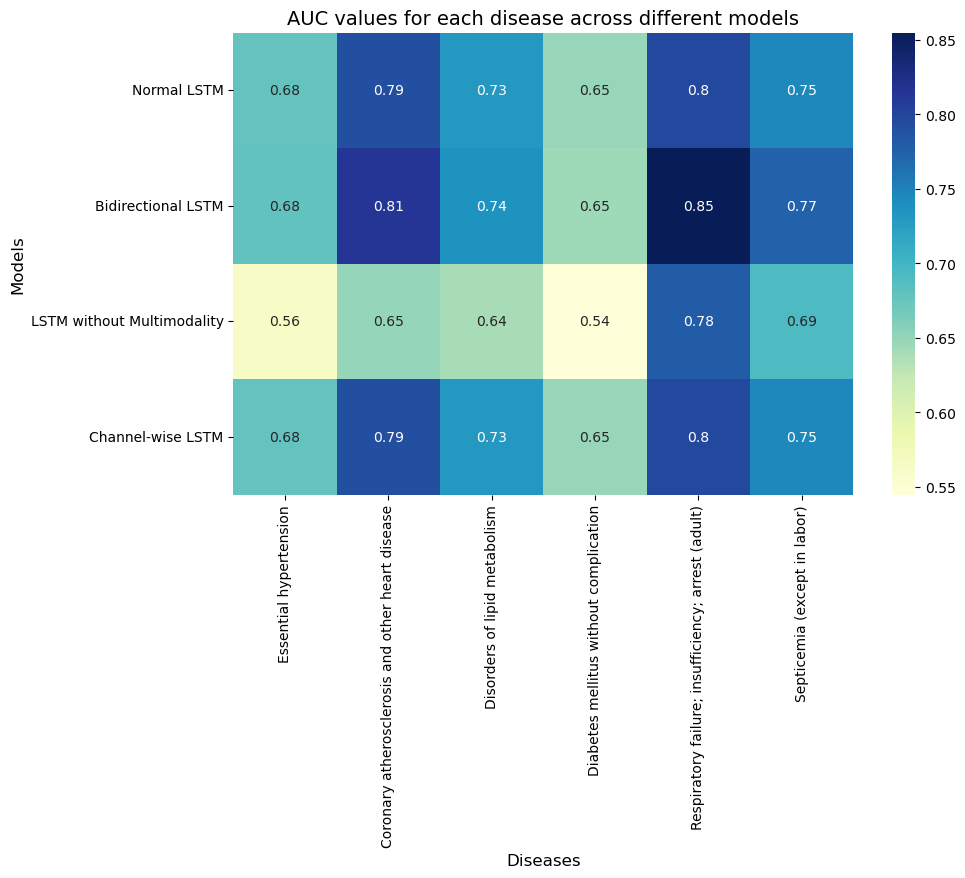

In [108]:
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# List of models and their names
models = [model, model1, model2, model3]
model_names = ["Normal LSTM", "Bidirectional LSTM", "LSTM without Multimodality", "Channel-wise LSTM"]

# Disease names
disease_names = [
    "Essential hypertension",
    "Coronary atherosclerosis and other heart disease",
    "Disorders of lipid metabolism",
    "Diabetes mellitus without complication",
    "Respiratory failure; insufficiency; arrest (adult)",
    "Septicemia (except in labor)"
]

# To store AUC values for heatmap
auc_values = []

for idx, model in enumerate(models):
    # Predict probabilities
    if model_names[idx] == "LSTM without Multimodality":
        y_pred = model.predict(padded_test_data)
    else:
        y_pred = model.predict([padded_test_data, test_data_static])
    
    # Compute and print micro and macro AUC-ROC
    roc_auc_micro = roc_auc_score(test_label, y_pred, average="micro")
    roc_auc_macro = roc_auc_score(test_label, y_pred, average="macro")
    print(f"{model_names[idx]} - Micro AUC-ROC: {roc_auc_micro:.4f}")
    print(f"{model_names[idx]} - Macro AUC-ROC: {roc_auc_macro:.4f}")
    
    # Classification report
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # Convert probabilities to binary outputs
    print(classification_report(test_label, y_pred_binary, target_names=disease_names))
    
    # Plot ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    test_label_arr = np.array(test_label)
    for i in range(6):  # Assuming 6 classes
        fpr[i], tpr[i], _ = roc_curve(test_label_arr[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{disease_names[i]} (AUC = {roc_auc[i]:.2f})', linewidth=1.5)
    
    plt.title(f'ROC Curve - {model_names[idx]}', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.show()
    
    # Store AUC values for heatmap
    auc_values.append([roc_auc[i] for i in range(6)])

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(auc_values, annot=True, cmap="YlGnBu", cbar=True, xticklabels=disease_names, yticklabels=model_names)
plt.title('AUC values for each disease across different models', fontsize=14)
plt.xlabel('Diseases', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.show()


In [129]:
auc_values

[[0.68, 0.82, 0.73, 0.65, 0.83, 0.76],
 [0.6802430956256165,
  0.8138313068899077,
  0.7365300331797384,
  0.6452804940813175,
  0.8548468193047545,
  0.7746647640188152],
 [0.5639224265778016,
  0.649940718797468,
  0.6394398688508082,
  0.5449253731343284,
  0.779739182815767,
  0.6922574916759157],
 [0.6776576679868497,
  0.7917641513108306,
  0.7305374781967184,
  0.6483014320842422,
  0.7956689479392813,
  0.745316209502669]]

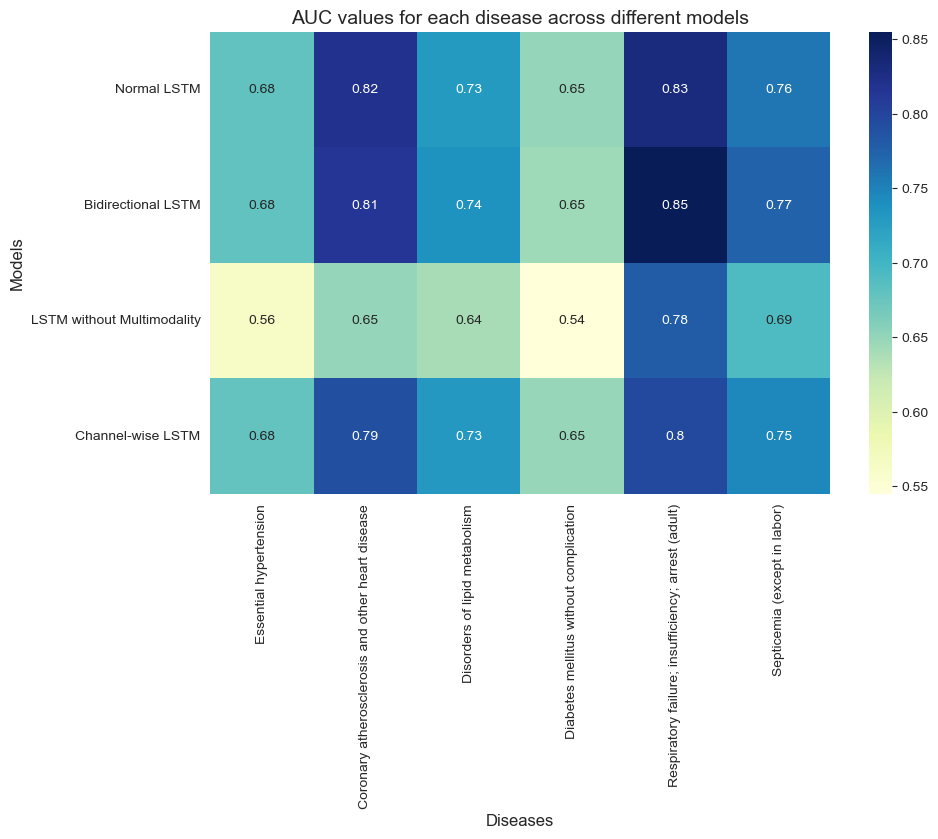

In [130]:
plt.figure(figsize=(10, 6))
sns.heatmap(auc_values, annot=True, cmap="YlGnBu", cbar=True, xticklabels=disease_names, yticklabels=model_names)
plt.title('AUC values for each disease across different models', fontsize=14)
plt.xlabel('Diseases', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.show()

In [ ]:
Normal LSTM - Micro AUC-ROC: 0.7844
Normal LSTM - Macro AUC-ROC: 0.7466

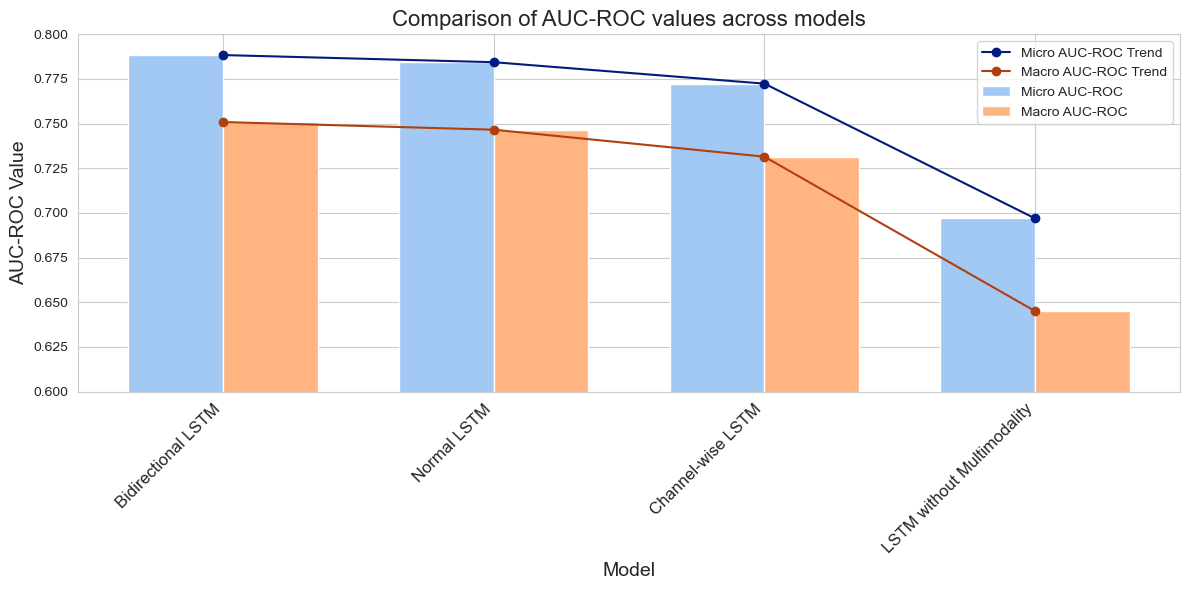

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model names and AUC-ROC values
model_names = ["Normal LSTM", "Bidirectional LSTM", "LSTM without Multimodality", "Channel-wise LSTM"]
micro_auc_values = [0.7844, 0.7884, 0.6969, 0.7724]
macro_auc_values = [0.7466, 0.7509, 0.6450, 0.7315]

# Combine the data and sort by Micro AUC-ROC values
data = list(zip(model_names, micro_auc_values, macro_auc_values))
data.sort(key=lambda x: x[1], reverse=True)  # Sort by Micro AUC-ROC
sorted_model_names, sorted_micro_auc, sorted_macro_auc = zip(*data)

# Set up the bar positions
bar_width = 0.35
index = np.arange(len(sorted_model_names))

# Create the bars
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Bars for Micro AUC-ROC
bar1 = plt.bar(index - bar_width/2, sorted_micro_auc, bar_width, color=sns.color_palette("pastel")[0], label='Micro AUC-ROC')

# Bars for Macro AUC-ROC
bar2 = plt.bar(index + bar_width/2, sorted_macro_auc, bar_width, color=sns.color_palette("pastel")[1], label='Macro AUC-ROC')

# Overlaying line chart
plt.plot(index, sorted_micro_auc, color=sns.color_palette("dark")[0], marker='o', label='Micro AUC-ROC Trend')
plt.plot(index, sorted_macro_auc, color=sns.color_palette("dark")[1], marker='o', label='Macro AUC-ROC Trend')

# Label the chart
plt.xlabel('Model', fontsize=14)
plt.ylabel('AUC-ROC Value', fontsize=14)
plt.title('Comparison of AUC-ROC values across models', fontsize=16)
plt.xticks(index, sorted_model_names, rotation=45, ha='right', fontsize=12)
plt.ylim(0.6, 0.8)
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()




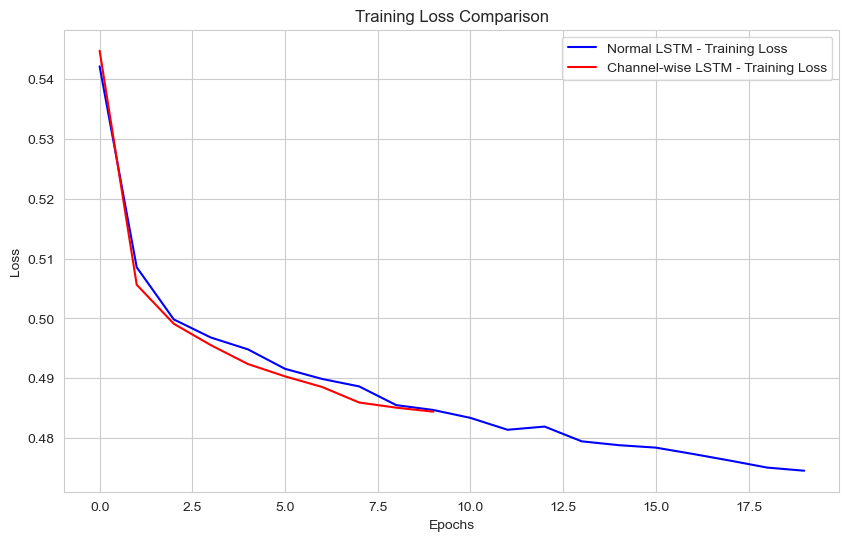

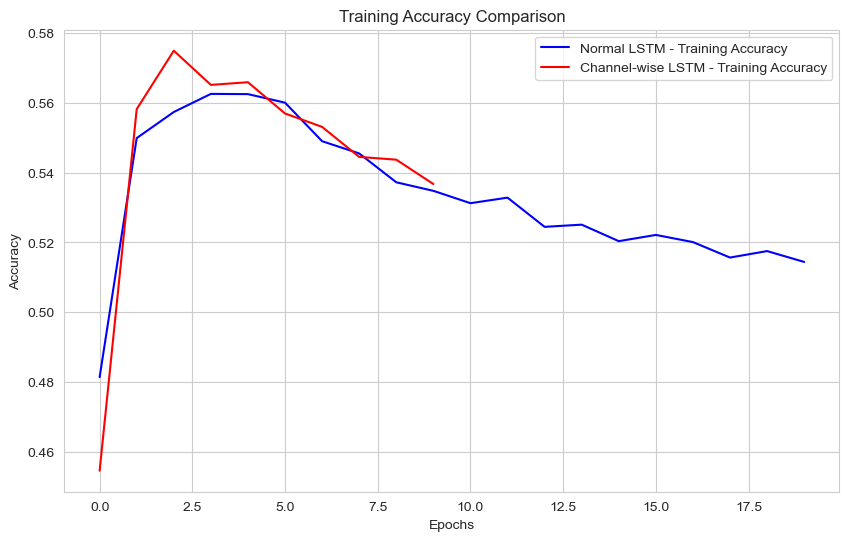

In [125]:
import matplotlib.pyplot as plt

# Plotting training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Normal LSTM - Training Loss', color='blue')
plt.plot(history3.history['loss'], label='Channel-wise LSTM - Training Loss', color='red')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Normal LSTM - Training Accuracy', color='blue')
plt.plot(history3.history['accuracy'], label='Channel-wise LSTM - Training Accuracy', color='red')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

